<font color=gray>ADS Sample Notebook.

Copyright (c) 2020 Oracle, Inc.  All rights reserved.
Licensed under the Universal Permissive License v 1.0 as shown at https://oss.oracle.com/licenses/upl.
</font>

***
# <font color=red>Interaction with Model Catalog and Projects</font>
<p style="margin-left:10%; margin-right:10%;">by the <font color=teal> Oracle ADS Team </font></p>

***

## Overview of this Notebook
This notebook provides a comprehensive coverage of all the CRUD operations you can do on models and projects with ADS, including how to save models built from ADS to the model catalog, how to list models/ edit models and load a model from the catalog, etc. 

The purpose of the model catalog is to provide a managed and centralized storage for model artifacts. The model catalog ensures that artifacts are immutable, facilitate model sharability and reproducibility. 

## Prerequisites:
 - Experience with specific topic: Novice
 - Professional experience: None

## Objectives:
By the end of this tutorial, you will know how to:
 - <a href='#load'>Loading a Toy Dataset using ADS</a>
 - <a href='#model'>Build and Train Simple Sklearn Models</a> 
 - <a href='#mc'>Interacting with the Model Catalog</a>
      - <a href='#prepare'>Preparing a Model Artifact for Storage in the Catalog from ADSModel</a>
          - <a href='#prepare'>From An ADSModel</a>
          - <a href='#prepare'>From Any Generic Model Type</a>
      - <a href='#save'>Saving a Model to the Catalog</a>
      - <a href='#listing'>Listing Models in the Catalog</a> 
      - <a href='#downloading'>Downloading a Model Artifact to your Notebook Session Environment</a>
      - <a href='#inference'>Loading an `ADSModel` instance from the Model Artifact and Calling the Model</a> 
      - <a href='#cat-other-ops'>Other Operations on the Catalog</a>
 - <a href='#fn'>Deploying a Model as an Oracle Function</a>     
 - <a href='#projects'>Appendix I - Operations on `Projects`</a>
 ***

Let's first start by importing all the necessary libraries we need to run this notebook. 

In [1]:
import pandas as pd
from sklearn.utils import Bunch

import os

import warnings
warnings.filterwarnings('ignore')

import logging
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.ERROR)

from ads.dataset.factory import DatasetFactory

<a id='load'></a>
# Loading a Toy Dataset using ADS

<font color=gray> (You can load from: a local or network file system, Hadoop Distributed File System, Amazon S3, Google Cloud Service, Pandas, Dask, or H2O. And in any of the following formats: CSV, TSV, Parquet, libsvm, json, Excel, HDF5, SQL, xml, apache server log files (clf, log) and arff.)</font>

In the cell below, we're going to use the ADS DatasetFactory object to pull a dataset CSV file from the local notebook environment. While loading the data to memory, ADS will also create a sampled dataset that will be used to speed up visualizations. A progress bar indicates the progress of these operations to the user.

<font color=gray> If you don't yet know the target in your project, you can explore the data first and set the target later.</font>

<font color=gray>Datasets are provided as a convenience.  Datasets are considered Third Party
Content and are not considered Materials under Your agreement with Oracle
applicable to the Services.  You can access the `oracle_classification_dataset1` dataset license [here](oracle_data/UPL.txt). 
Dataset `oracle_classification_dataset1` is distributed under UPL license. 
</font>

In [2]:
ds = DatasetFactory.open("/home/datascience/ads-examples/oracle_data/oracle_classification_dataset1_150K.csv", target="class")

<a id='model'></a>
# Build and Train Simple Sklearn Models

First we are going to first apply some basic transformations using the `auto_transform()` method and apply a train/test split on the data. Then we are training two simple sklearn models: a random forest classifier and a logistic regresssion model. 

These two models will be saved to the model catalog. 

In [3]:
# Let's apply some simple data transformation to that dataset: 
transformed_ds = ds.auto_transform(fix_imbalance=False)
train, test = transformed_ds.train_test_split(test_size=0.15)
X_train = train.X.values
y_train = train.y.values
X_test = test.X.values
y_test = test.y.values

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Two simple sklearn models: 
rf_clf = RandomForestClassifier(n_estimators=10).fit(X_train, y_train)
lr_clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial').fit(train.X, train.y)

<a id='mc'></a>
# Interacting with the Model Catalog

<a id='prepare'></a>
## Preparing a Model Artifact for Storage in the Catalog

### From an ADSModel

Running the following cell will create two `ADSModel` objects: `rf_model`and `lr_model`. Note that the `ADSModel` object API allows you to convert models from a variety of libraries (sklearn, xgboost, lightGBM, keras, tensorflow) into an `ADSModel` object. Simply use the `from_estimator()` method. We also have a notebook example `ads_model_feature_1.ipynb` that shows how you can convert different models into `ADSModel` objects. 

By converting models to the `ADSModel` type, you can continue to use various features of ADS: Model Evaluation, Explanation, etc.

In [4]:
# we are converting here these two sklearn models to ADSModel instances. These are the two 
# models we will save to the model catalog. 
from ads.common.model import ADSModel
rf_model = ADSModel.from_estimator(rf_clf)
lr_model = ADSModel.from_estimator(lr_clf)

Once an `ADSModel` object has been created the next step in the process is to prepare a model artifact. A model artifact is a zip archive containing all the necessary files to load and run the model in a different notebook session or outside of the OCI Data Science service altogether. The model artifact also contains the files necessary to deploy the model as an Oracle Function. 

The Model Catalog is a managed storage service for model artifacts. 

In [5]:
%load_ext autoreload
%autoreload 2
from ads.catalog.model import ModelSummaryList, ModelCatalog
from ads.catalog.project import ProjectSummaryList, ProjectCatalog
from ads.catalog.summary import SummaryList
from ads.common.model_artifact import ModelArtifact
from sklearn.utils import Bunch

To prepare an artifact, simply call the `prepare()` method of an `ADSModel` object. The only required argument is the local path to the folder where you want to store the artifact. We recommend that you store your artifacts under the `block_storage/` directory as everything in that directory is preserved if you de-activate your notebook session. 

ADS will generate automatically all the files necessary to create the artifact. That is also part of the `prepare()` step. 

In [6]:
path_to_model_artifact = "/home/datascience/block_storage/model"
model_artifact = rf_model.prepare(path_to_model_artifact, force_overwrite=True)

Generated model artifact files under '/home/datascience/block_storage/model'. Please update the inference script (score.py) as required.


### From Any Generic Model Type

If you don't need to create an `ADSModel` for Evaluation or Explanation, you can simply serialize your model and create an artifact from that. That too can be deployed as an Oracle Function, and managed by the ModelCatalog in exactly the same way. Below we demonstrate how to create this artifact using the `joblib` serializer, and the `rf_clf` from the `Build and Train` step above.

In [ ]:
from ads.common.model_export_util import prepare_generic_model
import joblib

path_to_generic_model_artifact = "/home/datascience/block_storage/generic_model"
!mkdir /home/datascience/block_storage/generic_model

joblib.dump(rf_clf, path_to_generic_model_artifact + "/model.pkl")
generic_model_artifact = prepare_generic_model(path_to_generic_model_artifact)

This `Model Artifact` will functionally be exactly the same as the one created from the `ADSModel` above.

Let's now take a look at the files in those model artifacts: 

In [ ]:
!ls /home/datascience/block_storage/model

In [ ]:
!ls /home/datascience/block_storage/generic_model

The first file is `score.py`. This Python module includes the functions needed to load the model to memory (`load_model()`) and make predictions (`predict()`). 

In [ ]:
!cat /home/datascience/block_storage/model/score.py

We encapuslated the list of all Python libraries installed in the notebook environment in the `ds-requirements.txt` file. This ensures that a user can reproduce the notebook session environment in which that particular model was trained. 

In [ ]:
# we're only showing the first 15 libraries listed in the requirements file. 

!head -n 15 /home/datascience/block_storage/model/ds-requirements.txt

The file `ds-runtime.yaml` is not used at the moment. 

In [ ]:
!cat /home/datascience/block_storage/model/ds-runtime.yaml

Let us prepare the model artifact for the other `ADSModel` we created: `lr_model`. We'll use a different target directory for the artifact. 

In [ ]:
path_to_model_artifact2 = "/home/datascience/block_storage/model2"
model_artifact2 = lr_model.prepare(path_to_model_artifact2, force_overwrite=True)
model_artifact2

In the cell below we show you an example of how you may want to customize the content of `score.py`. We modified the `_handle_input()` function to format the data before passing it to the model inference endpoint in `predict()`. 

In [ ]:
%%writefile /home/datascience/block_storage/model2/score.py

import os

from cloudpickle import cloudpickle

"""
   Inference script. This script is used for prediction by scoring server when schema is unknown.
"""


def load_model():
    """
    Loads model from the serialized format

    Returns
    -------
    model:  a model instance on which predict API can be invoked
    """
    with open(os.path.join(os.path.dirname(os.path.realpath(__file__)), "model.pkl"), "rb") as file:
        return cloudpickle.load(file)


def predict(data, model=load_model()):
    """
    Returns prediction given the model and data to predict

    Parameters
    ----------
    data: `data` is passed to the model inference endpoint (usually `predict()`) after being processed by the function `_handle_input()`. `_handle_input()` expects `data` to be a stringyfield JSON. Modify `_handle_input()` if you want `data` to be in a different format.
    model: Model instance returned by load_model API
    `warning -` If predict method will be called frequently, the performance may be affected by repeated invokation of `load_model`. You may consider to store it into a varialbe within the module and pass that model. Eg. - 
    `_model = load_model()`
    `def predict(data, model = _model)`

    Returns
    -------
    predictions: Json formatted prediction

    """
    data = _handle_input(data)
    return _handle_output(model.predict(data))


def _handle_input(data):
    """
    Convert input data to the format that model expects

    Parameters
    ----------
    data: input data

    Returns
    -------
    transformed_input: Should match the input format for model.predict() API
    """
    import pandas as pd
    return pd.DataFrame(data, columns=['col01', 'col02', 'col03', 'col04', 'col05', 'col06', 'col07', 'col08',
       'col09', 'col010', 'col011', 'col012', 'col013', 'col014', 'col015',
       'col016', 'col017', 'col018', 'col019', 'col020', 'col021', 'col022',
       'col023', 'col024', 'col025', 'col026', 'col027', 'col028', 'col029',
       'col030', 'col031', 'col032', 'col033', 'col034', 'col035', 'col036',
       'col037', 'col038', 'col039', 'col040', 'col041', 'col042', 'col043',
       'col044', 'col045', 'col046', 'col047', 'col048'])


def _handle_output(predictions):
    """
    Converts output to the format that model prediction endpoint should return

    Returns
    -------
    transformed_output: Predict endpoint response
    """
    return predictions


By calling `reload()` you are essentially committing any changes you have made to `score.py`. Make sure to `reload()` if you made changes to `score.py` before saving your artifact to the catalog.

In [ ]:
model_artifact2.reload()

In [ ]:
model_artifact2.predict(test.X.values[:10])

<a id='save'></a>
## Saving a Model to the Model Catalog 

The next step is to take that model artifact and save it to the model catalog. To do so, you will need to assign a project and compartment OCID to your model. An [OCID](https://docs.cloud.oracle.com/iaas/Content/General/Concepts/identifiers.htm) is an Oracle-assigned unique ID (Oracle Cloud Identifier -- OCID). It is included as part of the 
resources information in both the Console and the API. Note that projects, notebook sessions and models are OCI resources and consequently they have OCIDs too. 

We have included those values as environment variables in your notebook session. In fact you can access the following four OCIDs as environment variables: 

* `PROJECT_OCID`: Project OCID attached to this notebook session
* `NB_SESSION_OCID`: OCID of this notebook session
* `NB_SESSION_COMPARTMENT_OCID`: Compartment OCID of this notebook session 
* `USER_OCID`: Your user OCID. 

In the cell below we save the model in the same compartment as the notebook session and in the same project as the project associated with this notebook session. In principle, you can save your model into a different project and or compartment than the currently running notebook sessions: this allows you to isolate certain models in different compartments or use a dev-staging-prod approach to your models. 

In [ ]:
compartment_id = os.environ['NB_SESSION_COMPARTMENT_OCID']
project_id = os.environ["PROJECT_OCID"]

# Saving the model artifact to the model catalog: 
mc_model = model_artifact.save(project_id=project_id, compartment_id=compartment_id, display_name="my_model",
                                 description="test description", training_script_path="ads_ModelCatalog_1.ipynb", ignore_pending_changes=True)
mc_model

The output cell above should display metadata about the model you just saved. You can verify that your model is stored in the model catalog by going in your project page under `Models` as shown below: 

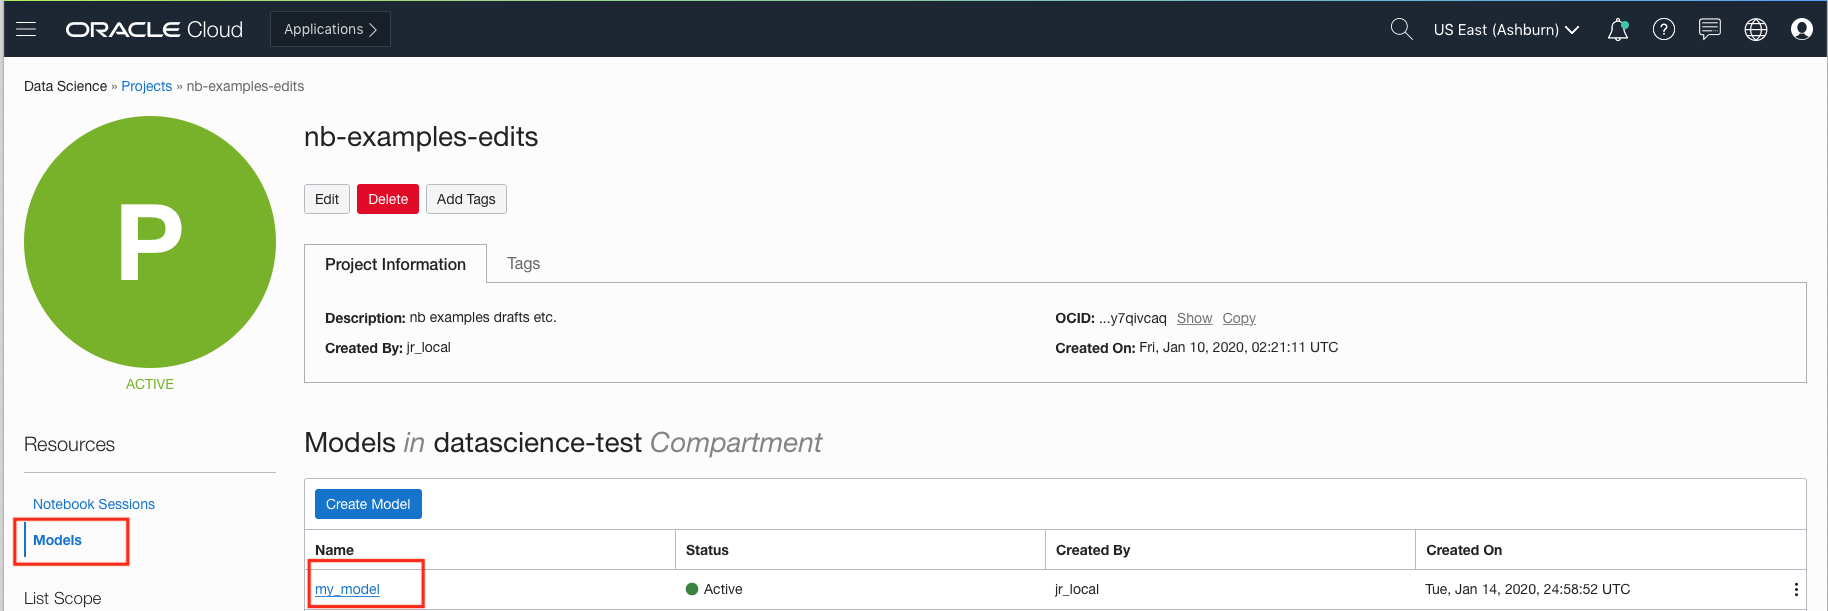

Your model has been saved successfully to the model catalog! 

<a id='listing'></a>
## Listing Models in the Catalog

Now let's suppose that you have saved models to the model catalog and you now want to load them in a different notebook session. Perhaps you want to share that model with a colleague who works in the same project. You can load a model to memory from the model catalog by using ADS. 

Unless you have the OCID of the model you want to load, you may want to list the content of the model catalog. As users can put models in different isolated compartments, you need to specify a compartment OCID to list the content of the model catalog. 

Let's start by creating an instance of the `ModelCatalog` object: 

In [ ]:
mc = ModelCatalog(compartment_id = os.environ['NB_SESSION_COMPARTMENT_OCID'])
type(mc)

The `ModelCatalog` API allows you to list, delete, download, update, and upload models easily. We are going to list models first. You should see at least two models in this list: the two models you saved earlier in the same compartment 

In [ ]:
mc.list_models()

In [ ]:
my_model_list = mc.list_models()
type(my_model_list)

`my_model_list` is an instance of the `ModelSummaryList` object: 

```
ads.catalog.model.ModelSummaryList
```

It is essentially a list that you can manipulate in different ways. You can select a model by applying a simple `filter()` to the list. In the cell below, we included a simple snippet to filter entries. Replace value with your user name: 

In [ ]:
your_user_name = '<your-user-name>'
my_new_list = []

if your_user_name != '<your-user-name>': 
    my_new_list = my_model_list.filter(lambda x: x.user_name==your_user_name)
my_new_list

You can also convert to a Pandas dataframe directly from the `ModelSummaryList` by calling: 

In [ ]:
pandas_df = my_model_list.df
type(pandas_df)

From there it becomes very easy to sort and filter your model list just like you would sort and filter a Pandas dataframe. For example below 
we sort by the name of the model and we select the first entry: 

In [ ]:
pandas_df.sort_values('display_name', axis=0)[:1]

You can also access a particular entry by specifying the position in the list. For example: 

In [ ]:
my_model_list[0]

Once you have found the model or models you want to load, the next step is to download the artifact from the catalog into your notebook session environment. 

<a id='downloading'></a>
## Downloading a Model Artifact to your Notebook Session Environment

You can use the `download_model()` of the `ModelCatalog` object to download an artifact locally. `download_model` requires a model OCID value as well as a target directory for the artifact file. We are going to download the first model in the model list we created above. If you know the OCID of your model you can pass it directly to `download_model()`. 

In [ ]:
path_to_my_loaded_model = '/home/datascience/block_storage/model3'
mc.download_model(my_model_list[0].id, path_to_my_loaded_model, force_overwrite=True)

<a id='inference'></a>
## Loading the `ADSModel` instance from the Model Artifact and Calling the Model

Next we are going to load this model artifact: 

In [ ]:
model_artifact = ModelArtifact(path_to_my_loaded_model)

Next we are going to load that artifact to memory and extract the `ADSModel` object from it: 

In [ ]:
model_artifact.reload()
model3 = model_artifact.model
type(model3)

You should see an output similar to: 

```
ads.common.model.ADSModel
```

model2 is an `ADSModel` object. 

Finally, we can use the inference method on the `ADSModel` object to make predictions on new data entries: 

In [ ]:
model3.predict(X_test[1:10])

You should seen an output similar to this: 

```
array([1., 0., 0., 0., 1., 0., 1., 1., 1.])
```

Within a few cells you were able to load and train a model with `ADS`, save the model artifact to the model catalog, and load that same model in your notebook session as a different `ADSModel`. This is the preferred way to share models among members of a data science team and across notebook sessions. 

## Other Operations on Models and Model Catalog 

Here we go over some additional operations you can take on models in the catalog. First let's connect to the `ModelCatalog`: 

In [ ]:
mc = ModelCatalog(compartment_id = os.environ['NB_SESSION_COMPARTMENT_OCID'])

You can delete a model by calling `delete_model()` with the OCID of the model you want to delete. We're going to delete the first model in the list: 

In [ ]:
mc.delete_model(mc.list_models()[0].id)

You can confirm that your model has been deleted by running `list_models()` again or by going to the OCI Console. 

In [ ]:
mc.list_models()

Now we are going to select a model from the list of models. You can get a model in a couple of ways. You can use the `get_model()` method of the `ModelCatalog()` or by directly selecting an entry in the list. For `get_model()`, simply specify the OCID of the model (which can be accessed via the `list_models()` method). 

`retrieved_model_1` is the same model as `retrieved_model_2`: 

In [ ]:
# these two ways of pulling a model are equivalent: 

retrieved_model_1 = mc.get_model(mc.list_models()[0].id)
retrieved_model_2 = mc.list_models()[0]

Now let's go over some additional operations you can apply to a `Model` instance: 

#### `show_in_notebook()` 

Call to `show_in_notebook()` provides a visual interface to the model metadata: 

In [ ]:
retrieved_model_1.show_in_notebook()

#### `deactivate()`

`deactivate()` is similar to archiving a model. By `deactivating` a model, the model is marked as `Inactive` and is not returned on default queries to the model catalog. Though the artifact is not deleted if you `deactivate` a model. 

All updates on a model need to be followed by a `commit()` call to push those changes to the model catalog. `deactivating()` is good for tracking old models you don't intend on using anymore or you want to keep as a reference. 

In [ ]:
retrieved_model_1.deactivate()
retrieved_model_1.commit()

#### `activate()`

Similarly you can activate a model that has been de-activated: 

In [ ]:
retrieved_model_1.activate()
retrieved_model_1.commit()

#### Updating model name or description 

You can change the name and description of your model: 

In [ ]:
retrieved_model_1.display_name = "new_name"
retrieved_model_1.description = "new description"
retrieved_model_1.commit()

#### Display Model Provenance Metadata 

When you clone an existing `git` repo and commit your notebooks or python scripts, `ADS` automatically extracts the latest commit information and store that information as part of the model provenance metadata: 

In [ ]:
retrieved_model_1.provenance_metadata

<a id='fn'></a>
# Deploying a Model as an Oracle Function 

A model artifact can also be deployed as an [Oracle Function](https://docs.cloud.oracle.com/iaas/Content/Functions/Concepts/functionsoverview.htm). The files for Function deployment are located in the `fn-folder/` of the model artifact. We have a notebook example on [deploying machine learning models to Oracle Functions](./ADS_Model_Deployment.ipynb) (`ADS_Model_Deployment.ipynb`). Please follow the instructions in that notebook. 

<a id='projects'></a>
# Appendix I - Operations on `Projects` 

`Projects` is another resource that is part of the Data Science service and ADS provides you an interface to perform operations on projects. 

## Listing Projects 

To list projects you need to provide a compartment OCID in which projects are found. we provie a `list_projects()` method to list these projects 

In [ ]:
compartment_id = os.environ['NB_SESSION_COMPARTMENT_OCID']

pc = ProjectCatalog(compartment_id=compartment_id)
type(pc)

Note that `pc` is an instance of the `ProjectCatalog` object. 

```
ads.catalog.project.ProjectCatalog
```

In [ ]:
pc.list_projects()

## Reading a Project Metadata

You can also retrieve a particular model from the list by using the `get_project()` method. Just pass the OCID of the project of interest: 

In [ ]:
my_project = pc.get_project(pc.list_projects()[0].id)
my_project.show_in_notebook()

The output cell will display the `OCID`, `description`, `display_name` etc. for that project. Instance `my_project` is of type `Project`. 

## Creating a Project

Once you have created an instance of `ProjectCatalog`, you can easily create a project by calling its `create_project()` method: 

In [ ]:
new_project = pc.create_project(display_name='test_project_from_ads',
                               description='this is a test project',
                               compartment_id=compartment_id)

In [ ]:
type(new_project)

You should be able to see your newly created project in the Console UI. `new_project` is an instance of `Project` object: 

```
oci.data_science.models.project.Project
```

## Updating a Project

Similar to models, you can also modify the name and description of a project. Use `commit()` to push those changes to the projects catalog 


In [ ]:
new_project.description = 'a new description'
new_project.display_name = 'a new name from ads'
new_project.commit()

In the output cell above, you should see the changes made to your project. 

## Deleting a Project 

You can also delete your newly created project: 

In [ ]:
pc.delete_project(new_project.id)

Go in the Console UI and confirm that the status is now `Deleted` for that project. 